In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from skimage import io
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


In [2]:
# Define the directory containing the TIFF files
data_dir = r"C:\Users\ASUA\OneDrive - Institut Teknologi Bandung\Geo-X\Rock Lens\python\Dataset Final\Porphyry_Final"

# Collect all TIFF file paths from the directory
raster_fns = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.tif')]

# Print total arrays to be processed
print(f"Total arrays collected: {len(raster_fns)}")


Total arrays collected: 18


In [3]:
# Initialize a dictionary to store flattened grayscale arrays
data_dict = {}

# Loop through each TIFF file, convert to grayscale, and flatten
for tiff_file in raster_fns:
    try:
        # Read the TIFF file as grayscale
        grayscale_array = io.imread(tiff_file, as_gray=True)

        # Flatten the 2D array into 1D
        flattened_array = grayscale_array.flatten()

        # Store the flattened array with the filename as the key
        data_dict[os.path.basename(tiff_file)] = flattened_array

        print(f"{os.path.basename(tiff_file)} shape: {flattened_array.shape}")

    except Exception as e:
        print(f"Failed to process {tiff_file}: {e}")


<tifffile.TiffPage 0 @8> parsing GDAL_NODATA tag raised ValueError('-3.4028234663852886e+38 is not castable to float32')
<tifffile.TiffPage 0 @8> parsing GDAL_NODATA tag raised ValueError('-3.4028234663852886e+38 is not castable to float32')
<tifffile.TiffPage 0 @8> parsing GDAL_NODATA tag raised ValueError('-3.4028234663852886e+38 is not castable to float32')
<tifffile.TiffPage 0 @8> parsing GDAL_NODATA tag raised ValueError('-3.4028234663852886e+38 is not castable to float32')


Advance Argilic_kandite_lowres.tif shape: (1008382,)
Argilic-Sericite-Smectite_lowres.tif shape: (1008382,)
Demnas Merged.tif shape: (1008382,)
gravitigrd10000_rtp_250full_fix.tif shape: (1008382,)
magnetikgrd10000_rtp_250full_fix.tif shape: (1008382,)
Muscovite_lowres.tif shape: (1008382,)
NDVI_Lowres.tif shape: (1008382,)
Porphyry.As_ppm.tif shape: (1008382,)
Porphyry.Au_ppb.tif shape: (1008382,)
Porphyry.Bi_ppm.tif shape: (1008382,)
Porphyry.Cu_ppm.tif shape: (1008382,)
Porphyry.MnO_pct.tif shape: (1008382,)
Porphyry.Mo_ppm.tif shape: (1008382,)
Porphyry.Pb_ppm.tif shape: (1008382,)
Porphyry.Sb_ppm.tif shape: (1008382,)
Porphyry.Zn_ppm.tif shape: (1008382,)
porphyry_labels.tif shape: (1008382,)
Proximity_fault.tif shape: (1008382,)


In [4]:
# Create a DataFrame from the dictionary
df = pd.DataFrame(data_dict)

# Remove ".tif" from column names for clarity
df.columns = [col.replace('.tif', '') for col in df.columns]

# Display the DataFrame shape and first few rows
print(f"DataFrame shape: {df.shape}")
print(df.head())


DataFrame shape: (1008382, 18)
   Advance Argilic_kandite_lowres  Argilic-Sericite-Smectite_lowres  \
0                        2.374147                          1.981707   
1                        2.264955                          1.993094   
2                        2.250363                          2.030109   
3                        2.336678                          2.019910   
4                        2.247231                          2.085587   

   Demnas Merged  gravitigrd10000_rtp_250full_fix  \
0          691.0                              1.0   
1          692.0                              1.0   
2          691.0                              1.0   
3          687.0                              1.0   
4          689.0                              1.0   

   magnetikgrd10000_rtp_250full_fix  Muscovite_lowres  NDVI_Lowres  \
0                               1.0          0.976372     0.282489   
1                               1.0          0.981585     0.201087   
2            

In [5]:
# Filter out rows with missing labels (unknown areas)
df_model = df[~df['porphyry_labels'].isna()]

# Define feature matrix and target variable
X = df_model.drop(columns=['porphyry_labels']).values  # Feature matrix
y = df_model['porphyry_labels'].values  # Target variable

# Define the full dataset (without labels) for prediction
X_full = df.drop(columns=['porphyry_labels']).values  # Full dataset for predictions

# Check shapes to ensure alignment
print(f"Training data shape: {X.shape}, Full data shape: {X_full.shape}")


Training data shape: (10403, 17), Full data shape: (1008382, 17)


In [6]:
# Separate features (X) and labels (Y)
Y = np.array(df_model.pop('porphyry_labels').values)
X = np.array(df_model)

# Verify shapes
print(f"Features shape: {X.shape}, Labels shape: {Y.shape}")


Features shape: (10403, 17), Labels shape: (10403,)


Model loaded successfully!


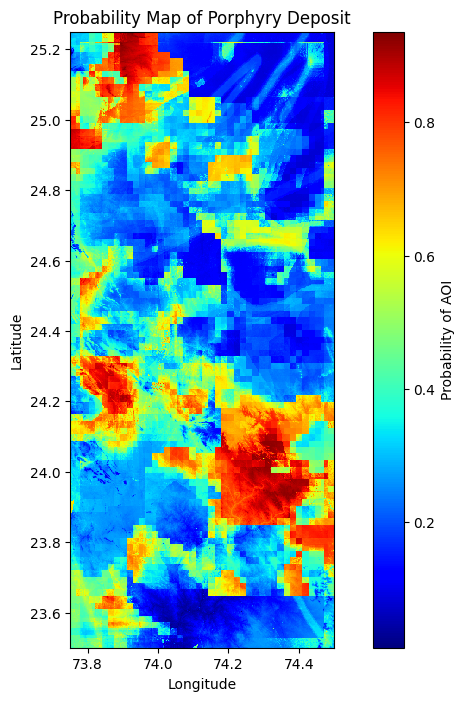

In [7]:
import joblib
import h5py
import numpy as np
import rasterio

# Load the model from the HDF5 file for specific deposit
model_path = 'best_model_porphyry.h5'
with h5py.File(model_path, 'r') as hf:
    model_data = hf['model'][()]  # Load the binary data

# Deserialize the model using joblib
import io
loaded_model = joblib.load(io.BytesIO(model_data.tobytes()))

print("Model loaded successfully!")

# Predict probabilities for the entire dataset (X_full)
y_prob_full = loaded_model.predict_proba(X_full)[:, 1]  # Probability of AOI (Class 1)

# Reshape probabilities back to the original raster shape
# Open a reference TIFF to get the shape
with rasterio.open(raster_fns[0]) as src:
    raster_shape = src.shape  # Extract the original raster shape (rows, cols)

# Ensure the probabilities are reshaped correctly into the original raster grid
probability_grid = y_prob_full.reshape(raster_shape)

# Plot the probability grid
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(probability_grid, cmap='jet', interpolation='nearest',
           extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top))
plt.colorbar(label='Probability of AOI')
plt.title('Probability Map of Porphyry Deposit')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
